In [2]:
%matplotlib inline
import datetime
import pysrt
import os
import textblob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

naban = textblob.en.sentiments.NaiveBayesAnalyzer()
pattan = textblob.en.sentiments.PatternAnalyzer()
naban.train()

# Analyzing time
### Talk time vs Duration, Avg(Talk time, Duration), Talk density!

In [3]:
def get_timedelta(sub):
    """Returns a timedelta for the sub."""
    t_start = sub.start.to_time()
    t_end = sub.end.to_time()
    
    td_start = datetime.timedelta(minutes=t_start.minute, seconds=t_start.second, microseconds=t_start.microsecond)
    td_end = datetime.timedelta(minutes=t_end.minute, seconds=t_end.second, microseconds=t_end.microsecond)
    
    return td_end - td_start

In [4]:
# get length for each series for each episode
seasons = {i: None for i in range(5)}
season_index = 0
os.chdir('subs_en')
for directory in os.listdir():
    if "season" in directory:
        os.chdir(directory)
        seasons[season_index] = [pysrt.open(s, encoding='iso-8859-1') for s in os.listdir()]
        season_index += 1
        os.chdir('../')

# talking time (in minutes)
talking_time = {i: [] for i in range(5)}
for season in range(5):
    for episode in seasons[season]:
        time_per_episode = sum([get_timedelta(sub).total_seconds() / 60 for sub in episode])
        talking_time[season].append(time_per_episode)

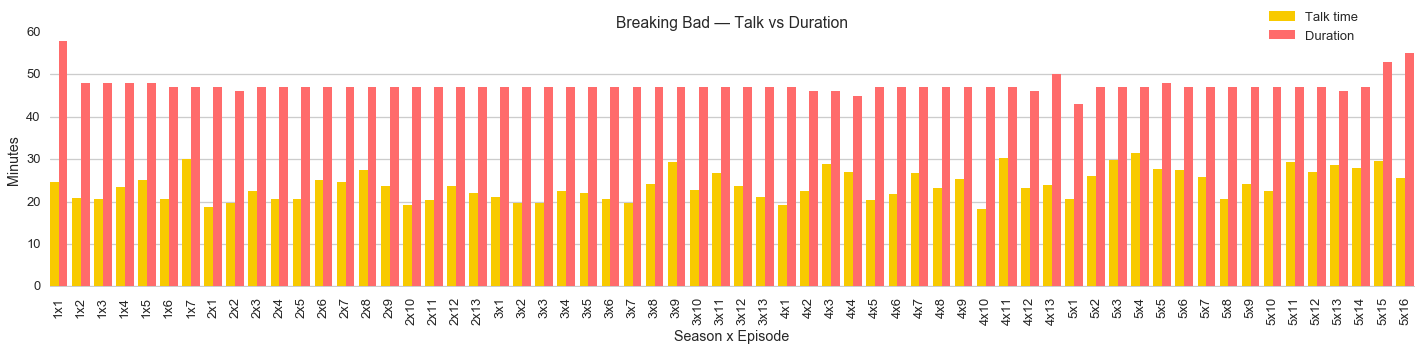

In [5]:
# plotting them
sns.set_style("whitegrid")
sns.set_context("talk")

## SET THIS IN ORDER TO SELECT THE SERIES
## and other stuff
target = range(5)
width_bar = .4

# talking time for episode and avg length for episode
talking_time_episode = [tt for i in target for tt in talking_time[i]]
with open('../lengths') as len_file:
    length_episode = [int(t) for line in len_file for t in line.strip().split(' ')]

# number of elements on the x-axis
indexes = np.arange(sum([len(talking_time[i]) for i in target]))
# labels for the x-axis
episodes_label = [str(i+1) + "x" + str(j+1) for i in target for j in range(len(talking_time[i]))]

fig, scene = plt.subplots(figsize=(20, 5))

# the bars
talktime_bar = plt.bar(indexes, talking_time_episode, width=width_bar, color='#F8CA00', edgecolor="none")
eplength_bar = plt.bar(indexes + width_bar, length_episode, width=width_bar, color='#FF6B6B', edgecolor="none")

# polyfit
#aa = np.array(indexes)
#bb = np.array(talking_time_episode)
#z = np.polyfit(aa, bb, 6)
#p = np.poly1d(z)
#talktime_fit = plt.plot(aa, [p(i) for i in aa], '-')

# tuning up
scene.set_xticks(indexes + width_bar)
scene.set_xticklabels(episodes_label)
scene.set_xlabel('Season x Episode')
scene.set_ylabel('Minutes')
scene.set_xlim(0, len(episodes_label)-.20)
scene.set_title("Breaking Bad — Talk vs Duration")

# remove all of the vertical lines
xlines = scene.get_xgridlines()
for xl in xlines:
    xl.set_linewidth(0)
# remove only the last horizontal line
scene.get_ygridlines()[-1].set_linewidth(0)

# legend
legend = plt.legend((talktime_bar, eplength_bar), ('Talk time', 'Duration'), loc=(.89,.94))
legend.get_frame().set_facecolor('white')

# some more settings
plt.xticks(rotation=90)
plt.tick_params(axis='x',top='off',bottom='off')
plt.tight_layout()
sns.despine(left=True, right=True)

plt.savefig('bb.png')

In [6]:
# avg values, so we compute the talk density of BB serie
avg_talking = np.mean(talking_time_episode)
avg_episodes = np.mean(length_episode)
print('Average talking is', round(avg_talking, 2), 'minutes and average length for an episode is', round(avg_episodes, 5), "minutes.")
print('Average talk density is', "{}%.".format(round((avg_talking / avg_episodes)*100, 2)))

# min value, max value
tmin, min_i = min((m, i) for (i, m) in enumerate(talking_time_episode))
tmax, max_i = max((m, i) for (i, m) in enumerate(talking_time_episode))
print("Minimum is at episode", episodes_label[min_i], "with", round(tmin, 5), "minutes and maximum is at episode {} with {} minutes.".format(episodes_label[max_i], round(tmax, 5)))

Average talking is 23.9 minutes and average length for an episode is 47.35484 minutes.
Average talk density is 50.47%.
Minimum is at episode 4x10 with 18.3275 minutes and maximum is at episode 5x4 with 31.4583 minutes.


48.16% 47.18% 47.93% 51.02% 55.77%


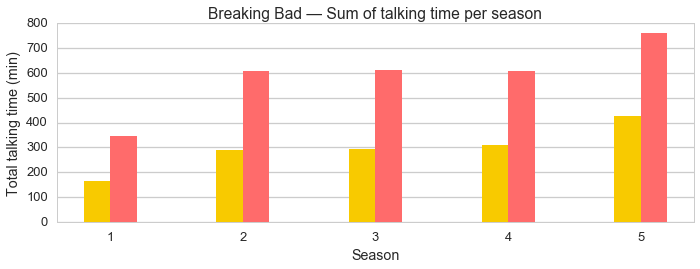

In [47]:
# sum of talk time per season
sum_per_season = [round(sum(talking_time[i]), 5) for i in range(5)]
with open('../lengths') as len_file:
    running_per_season = [sum(map(int, l.strip().split(' '))) for l in len_file]

fig, scene = plt.subplots(figsize=(10, 4))
plt.bar(np.arange(5) + .2, sum_per_season, width=.2, color='#F8CA00', edgecolor="none")
plt.bar(np.arange(5) + .4, running_per_season, width=.2, color='#FF6B6B', edgecolor="none")

# tuning up
scene.set_xticks(np.arange(5) + .4)
scene.set_xticklabels([str(i+1) for i in range(5)])
scene.set_xlabel('Season')
scene.set_ylabel('Total talking time (min)')
scene.set_xlim(0, 4.8)
scene.set_title("Breaking Bad — Sum of talking time per season")
# remove the horiz lines
xlines = scene.get_xgridlines()
for xl in xlines:
    xl.set_linewidth(0)

plt.tight_layout()

plt.savefig('bb_sum.png')

print(" ".join([str(round((sum_per_season[i] / running_per_season[i])*100, 2)) + '%' for i in range(5)]))

# Analyzing subtitles

First step is to *normalize* each `episode.text`.

In [49]:
from textblob import TextBlob
import re

# IDEA: se sono passati più di X secondi, allora metti un \n

normalized_episodes = []
for s_idx in range(5):
    for episode in seasons[s_idx]:
        # I get rid HTML tags and that annoying '
        ep = re.sub(r"\\", '', re.sub(r"<.*?>", '', episode.text))
        # episode.text is a string, I split them by \n
        ep = ep.split('\n')
        
        # if it starts with a lower case, I append it to the previous sentence
        i = 1
        while (i < len(ep)):
            sentence = ep[i]
            if sentence[0].islower():
                ep[i-1] = ' '.join([ep[i-1], sentence])
                del ep[i]
            i += 1
        
        # if it ends with "..." and the next starts with "..." and a lower case, so I join them
        i = 0
        while (i < len(ep)-1):
            curr_sentence = ep[i]
            next_sentence = ep[i+1]
            if curr_sentence[-3:] == "..." and next_sentence[:3] == '...' and next_sentence[4].islower():
                ep[i] = curr_sentence[:-3] + ' ' + next_sentence[3:]
                del ep[i+1]
                i -= 1
            i += 1
        
        normalized_episodes.append(ep)

In [50]:
# Positive or negative?
sentiments_for_episode_naban = [naban.analyze('\n'.join(ep)) for ep in normalized_episodes]
sentiments_for_episode_pattan = [pattan.analyze('\n'.join(ep)) for ep in normalized_episodes]

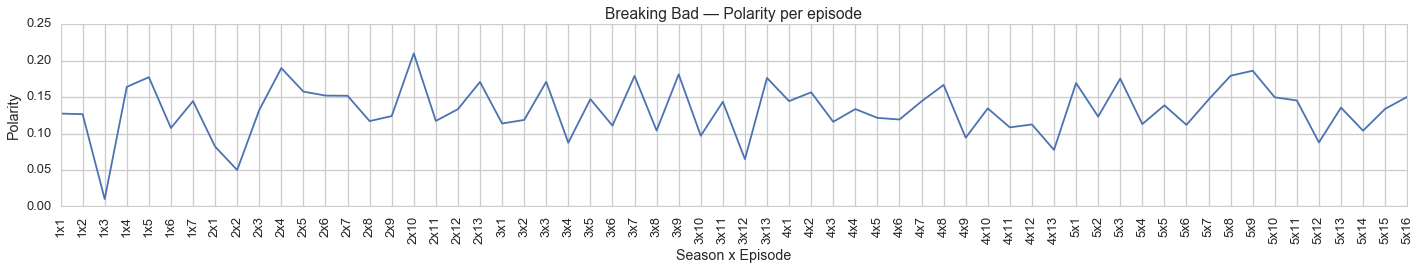

In [67]:
# that's for printing
#for i, label in enumerate(episodes_label):
#    classification = sentiments_for_episode_naban[i].classification
#    print(label, "POS" if classification == 'pos' else "NEG", "— POLARITY:", 
#          round(sentiments_for_episode_pattan[i].polarity, 5))

fig, scene = plt.subplots(figsize=(20, 4))
plt.plot(indexes, [p.polarity for p in sentiments_for_episode_pattan], linewidth=1.8)

# tuning up
scene.set_xticks(indexes)
scene.set_xticklabels(episodes_label)
scene.set_xlabel('Season x Episode')
scene.set_ylabel('Polarity')
scene.set_xlim(0, len(episodes_label)-1)
scene.set_title("Breaking Bad — Polarity per episode")

# some more settings
plt.xticks(rotation=90)
plt.tick_params(axis='x',top='off',bottom='off')
plt.tight_layout()

plt.savefig('bb_polarity.png')